In [10]:
import os
import pandas as pd
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import cv2

In [11]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

Using device: cpu


In [12]:
# Load Meta.csv to get class names
meta_df = pd.read_csv("data/Meta.csv")

# Create a mapping dictionary
CLASS_ID_TO_NAME = dict(zip(meta_df["ClassId"], meta_df["Path"].apply(lambda p: os.path.splitext(os.path.basename(p))[0])))

In [13]:
CLASS_ID_TO_NAME = {
    0: "Speed limit 20",
    1: "Speed limit 30",
    2: "Speed limit 50",
    3: "Speed limit 60",
    4: "Speed limit 70",
    5: "Speed limit 80",
    6: "End of speed limit 80",
    7: "Speed limit 100",
    8: "Speed limit 120",
    9: "No passing",
    10: "No passing for vehicles > 3.5t",
    11: "Right-of-way at intersection",
    12: "Priority road",
    13: "Yield",
    14: "Stop",
    15: "No vehicles",
    16: "No vehicles > 3.5t",
    17: "No entry",
    18: "General caution",
    19: "Dangerous curve left",
    20: "Dangerous curve right",
    21: "Double curve",
    22: "Bumpy road",
    23: "Slippery road",
    24: "Road narrows on the right",
    25: "Road work",
    26: "Traffic signals",
    27: "Pedestrians",
    28: "Children crossing",
    29: "Bicycles crossing",
    30: "Beware of ice/snow",
    31: "Wild animals crossing",
    32: "End of all restrictions",
    33: "Turn right ahead",
    34: "Turn left ahead",
    35: "Go straight",
    36: "Go straight or right",
    37: "Go straight or left",
    38: "Keep right",
    39: "Keep left",
    40: "Roundabout",
    41: "End of no passing",
    42: "End of no passing > 3.5t"
}

In [14]:
class TrafficSignCNN(torch.nn.Module):
    def __init__(self, num_classes=43):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = torch.nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = torch.nn.MaxPool2d(2, 2)
        self.dropout = torch.nn.Dropout(0.5)
        self.fc1 = torch.nn.Linear(128 * 4 * 4, 512)
        self.fc2 = torch.nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = self.dropout(F.relu(self.fc1(x)))
        return self.fc2(x)

In [15]:
model = TrafficSignCNN().to(DEVICE)
model.load_state_dict(torch.load("traffic_sign_cnn.pth", map_location=DEVICE))
model.eval()

TrafficSignCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=43, bias=True)
)

In [20]:
image_path = "data/test/00009.png"  # Example: Stop sign

In [21]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

image = Image.open(image_path).convert("RGB")
image_tensor = transform(image).to(DEVICE)

In [22]:
def generate_gradcam(model, image_tensor, class_idx, target_layer='conv3'):
    activations, gradients = [], []

    def forward_hook(module, input, output):
        activations.append(output)

    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])

    # Register hooks
    layer = getattr(model, target_layer)
    handle_f = layer.register_forward_hook(forward_hook)
    handle_b = layer.register_backward_hook(backward_hook)

    image_tensor = image_tensor.unsqueeze(0)  # Add batch dim
    output = model(image_tensor)
    model.zero_grad()
    output[0, class_idx].backward()

    handle_f.remove()
    handle_b.remove()

    act = activations[0].squeeze().cpu().detach().numpy()
    grad = gradients[0].squeeze().cpu().detach().numpy()
    weights = np.mean(grad, axis=(1, 2))

    cam = np.zeros(act.shape[1:], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * act[i]
    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (32, 32))
    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)

    return cam

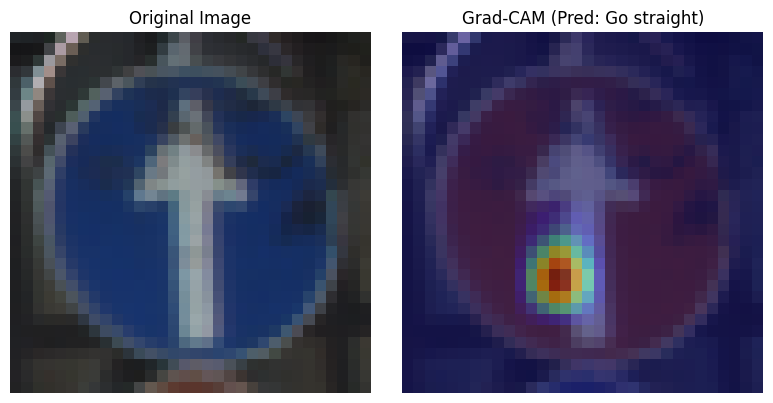

In [23]:
# Get prediction
with torch.no_grad():
    output = model(image_tensor.unsqueeze(0))
    pred_class = output.argmax(dim=1).item()

# Generate Grad-CAM
cam = generate_gradcam(model, image_tensor, class_idx=pred_class)

# Unnormalize image
image_np = image_tensor.permute(1, 2, 0).cpu().numpy()
image_np = (image_np * 0.5 + 0.5).clip(0, 1)

# Overlay heatmap
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
overlay = cv2.addWeighted(np.uint8(image_np * 255), 0.6, heatmap, 0.4, 0)

# Plot
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(image_np)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(overlay[:, :, ::-1])  # BGR to RGB
pred_label = CLASS_ID_TO_NAME.get(pred_class, f"Class {pred_class}")
plt.title(f"Grad-CAM (Pred: {pred_label})")
plt.axis("off")

plt.tight_layout()
plt.show()